In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***100%***

In [ ]:
train = '/content/drive/MyDrive/dataset1/train.csv'
val = '/content/drive/MyDrive/dataset1/validation.csv'
test = '/content/drive/MyDrive/dataset1/test-500.csv'

In [ ]:
import pandas as pd

train_data = pd.read_csv(train)
val_data = pd.read_csv(val)
test_data = pd.read_csv(test)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        if pd.isnull(text):
            text = ""  # Replace NaN with an empty string
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['label'])
val_labels = label_encoder.transform(val_data['label'])
test_labels = label_encoder.transform(test_data['label'])

# Tokenize and encode input sequences
max_length = 128
train_inputs, train_masks = tokenize_text(train_data['text'], tokenizer, max_length)
val_inputs, val_masks = tokenize_text(val_data['text'], tokenizer, max_length)
test_inputs, test_masks = tokenize_text(test_data['text'], tokenizer, max_length)

# Create PyTorch datasets
train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
test_dataset = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))

# Define data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', unit='batches'):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).tolist())
        val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}, Validation Accuracy: {val_accuracy}")

# Test the model
model.eval()
test_preds = []
test_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, labels = batch

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits

    test_preds.extend(torch.argmax(logits, dim=1).tolist())
    test_labels.extend(labels.tolist())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 986/986 [10:39<00:00,  1.54batches/s]


Epoch 1/10, Training Loss: 0.12623142452275807, Validation Accuracy: 0.9448459490300495


Epoch 2: 100%|██████████| 986/986 [10:43<00:00,  1.53batches/s]


Epoch 2/10, Training Loss: 0.0397970310565718, Validation Accuracy: 0.9581589958158996


Epoch 3: 100%|██████████| 986/986 [10:42<00:00,  1.53batches/s]


Epoch 3/10, Training Loss: 0.02209303524444278, Validation Accuracy: 0.9664004057309497


Epoch 4: 100%|██████████| 986/986 [10:42<00:00,  1.53batches/s]


Epoch 4/10, Training Loss: 0.014063808554100143, Validation Accuracy: 0.9582857867376696


Epoch 5: 100%|██████████| 986/986 [10:43<00:00,  1.53batches/s]


Epoch 5/10, Training Loss: 0.008773215580794354, Validation Accuracy: 0.9822492709521998


Epoch 6: 100%|██████████| 986/986 [10:43<00:00,  1.53batches/s]


Epoch 6/10, Training Loss: 0.007803488915238045, Validation Accuracy: 0.9721059972105998


Epoch 7: 100%|██████████| 986/986 [10:43<00:00,  1.53batches/s]


Epoch 7/10, Training Loss: 0.006809699983995384, Validation Accuracy: 0.9800938252821098


Epoch 8: 100%|██████████| 986/986 [10:42<00:00,  1.53batches/s]


Epoch 8/10, Training Loss: 0.005008507236284763, Validation Accuracy: 0.9779383796120198


Epoch 9: 100%|██████████| 986/986 [10:43<00:00,  1.53batches/s]


Epoch 9/10, Training Loss: 0.005246258371043876, Validation Accuracy: 0.9817421072651198


Epoch 10: 100%|██████████| 986/986 [10:42<00:00,  1.53batches/s]


Epoch 10/10, Training Loss: 0.0052634414423535425, Validation Accuracy: 0.9680486877139597
Test Accuracy: 0.968


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       248
           1       0.95      0.98      0.97       252

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



Confusion Matrix:
[[236  12]
 [  4 248]]


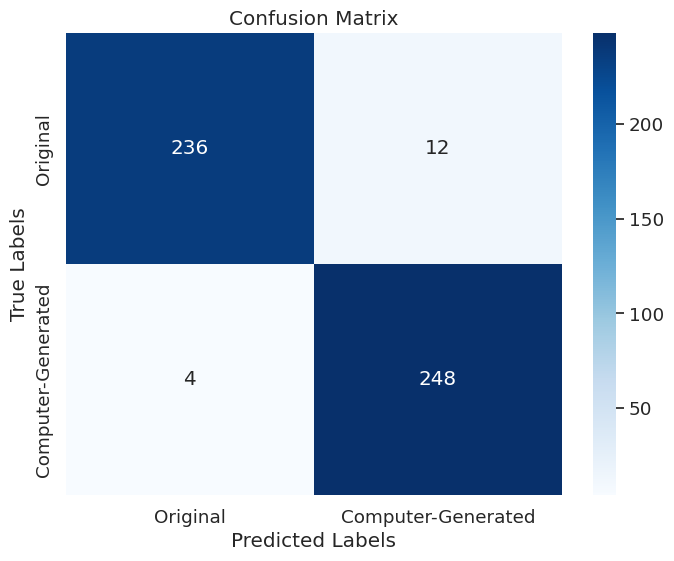

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(test_labels, test_preds)
print(cm)


# Define class labels
class_names = ['Original','Computer-Generated']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# ***50%***

In [ ]:
train = '/content/drive/MyDrive/dataset1/50/train50.csv'
val = '/content/drive/MyDrive/dataset1/50/val50.csv'
test = '/content/drive/MyDrive/dataset1/test-500.csv'

In [ ]:
import pandas as pd

train_data = pd.read_csv(train)
val_data = pd.read_csv(val)
test_data = pd.read_csv(test)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        if pd.isnull(text):
            text = ""  # Replace NaN with an empty string
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['label'])
val_labels = label_encoder.transform(val_data['label'])
test_labels = label_encoder.transform(test_data['label'])

# Tokenize and encode input sequences
max_length = 128
train_inputs, train_masks = tokenize_text(train_data['text'], tokenizer, max_length)
val_inputs, val_masks = tokenize_text(val_data['text'], tokenizer, max_length)
test_inputs, test_masks = tokenize_text(test_data['text'], tokenizer, max_length)

# Create PyTorch datasets
train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
test_dataset = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))

# Define data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', unit='batches'):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).tolist())
        val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}, Validation Accuracy: {val_accuracy}")

# Test the model
model.eval()
test_preds = []
test_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, labels = batch

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits

    test_preds.extend(torch.argmax(logits, dim=1).tolist())
    test_labels.extend(labels.tolist())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 1/10, Training Loss: 0.16645785903323887, Validation Accuracy: 0.9399087221095335


Epoch 2: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 2/10, Training Loss: 0.051727769996982226, Validation Accuracy: 0.970841784989858


Epoch 3: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 3/10, Training Loss: 0.021617128043369394, Validation Accuracy: 0.9452332657200812


Epoch 4: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 4/10, Training Loss: 0.013249066599136319, Validation Accuracy: 0.972870182555781


Epoch 5: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 5/10, Training Loss: 0.013105029527304088, Validation Accuracy: 0.9802231237322515


Epoch 6: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 6/10, Training Loss: 0.004343502272549038, Validation Accuracy: 0.9797160243407708


Epoch 7: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 7/10, Training Loss: 0.005863656106781126, Validation Accuracy: 0.9662778904665315


Epoch 8: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 8/10, Training Loss: 0.007238461568944051, Validation Accuracy: 0.9746450304259635


Epoch 9: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 9/10, Training Loss: 0.004566571914912218, Validation Accuracy: 0.9710953346855984


Epoch 10: 100%|██████████| 493/493 [05:06<00:00,  1.61batches/s]


Epoch 10/10, Training Loss: 0.004906514210724302, Validation Accuracy: 0.9647565922920892
Test Accuracy: 0.952


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       248
           1       0.93      0.98      0.95       252

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



Confusion Matrix:
[[229  19]
 [  5 247]]


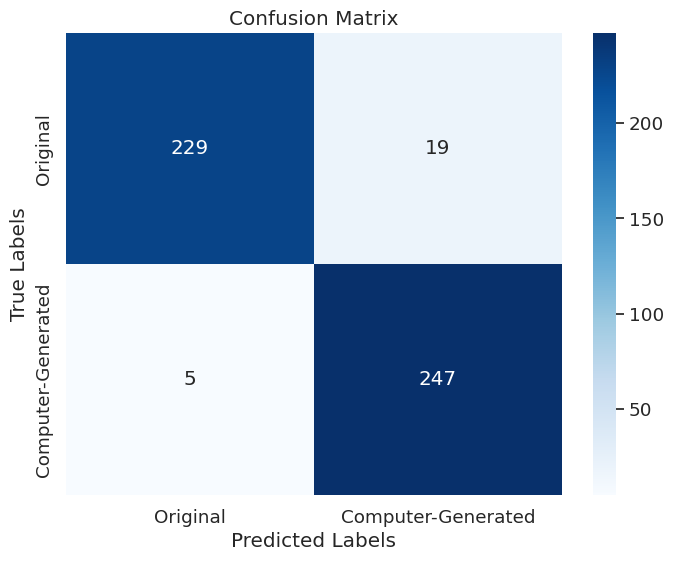

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(test_labels, test_preds)
print(cm)


# Define class labels
class_names = ['Original','Computer-Generated']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# ***10%***

In [ ]:
train = '/content/drive/MyDrive/dataset1/10/train10.csv'
val = '/content/drive/MyDrive/dataset1/10/val10.csv'
test = '/content/drive/MyDrive/dataset1/test-500.csv'

In [ ]:
import pandas as pd

train_data = pd.read_csv(train)
val_data = pd.read_csv(val)
test_data = pd.read_csv(test)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        if pd.isnull(text):
            text = ""  # Replace NaN with an empty string
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['label'])
val_labels = label_encoder.transform(val_data['label'])
test_labels = label_encoder.transform(test_data['label'])

# Tokenize and encode input sequences
max_length = 128
train_inputs, train_masks = tokenize_text(train_data['text'], tokenizer, max_length)
val_inputs, val_masks = tokenize_text(val_data['text'], tokenizer, max_length)
test_inputs, test_masks = tokenize_text(test_data['text'], tokenizer, max_length)

# Create PyTorch datasets
train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
test_dataset = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))

# Define data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', unit='batches'):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).tolist())
        val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}, Validation Accuracy: {val_accuracy}")

# Test the model
model.eval()
test_preds = []
test_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, labels = batch

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits

    test_preds.extend(torch.argmax(logits, dim=1).tolist())
    test_labels.extend(labels.tolist())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 99/99 [01:01<00:00,  1.60batches/s]


Epoch 1/10, Training Loss: 0.3602909661377921, Validation Accuracy: 0.9340937896070975


Epoch 2: 100%|██████████| 99/99 [01:01<00:00,  1.62batches/s]


Epoch 2/10, Training Loss: 0.08866193570723438, Validation Accuracy: 0.8846641318124208


Epoch 3: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 3/10, Training Loss: 0.03100865824627831, Validation Accuracy: 0.9404309252217997


Epoch 4: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 4/10, Training Loss: 0.02101903903472115, Validation Accuracy: 0.9188846641318125


Epoch 5: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 5/10, Training Loss: 0.018476417727387427, Validation Accuracy: 0.8986058301647655


Epoch 6: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 6/10, Training Loss: 0.017545162265617024, Validation Accuracy: 0.9252217997465145


Epoch 7: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 7/10, Training Loss: 0.011679921340376063, Validation Accuracy: 0.9594423320659062


Epoch 8: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 8/10, Training Loss: 0.01808836843496226, Validation Accuracy: 0.9391634980988594


Epoch 9: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 9/10, Training Loss: 0.0031470196053204644, Validation Accuracy: 0.935361216730038


Epoch 10: 100%|██████████| 99/99 [01:01<00:00,  1.61batches/s]


Epoch 10/10, Training Loss: 0.006351481776830336, Validation Accuracy: 0.9074778200253485
Test Accuracy: 0.902


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89       248
           1       0.85      0.98      0.91       252

    accuracy                           0.90       500
   macro avg       0.91      0.90      0.90       500
weighted avg       0.91      0.90      0.90       500



Confusion Matrix:
[[205  43]
 [  6 246]]


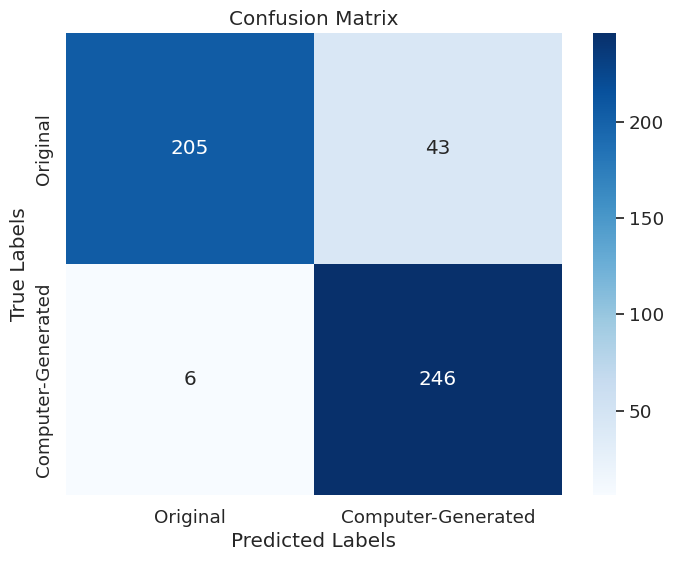

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(test_labels, test_preds)
print(cm)


# Define class labels
class_names = ['Original','Computer-Generated']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
